## ***dispy framework for parallel & distributed computations***

dispy is a generic, comprehensive, yet easy to use framework and tools for creating, using and managing compute clusters to execute computations in parallel across multiple processors in a single machine (SMP), among many machines in a cluster, grid or cloud. dispy is well suited for data parallel (SIMD) paradigm where a computation (Python function or standalone program) is evaluated with different (large) datasets independently with no communication among computation tasks (except for computation tasks sending Provisional/Intermediate Results or Transferring Files to the client). If communication/cooperation among tasks is needed, Distributed Communicating Processes module of pycos framework could be used.

# ***Features***

1. dispy is implemented with pycos, an independent framework for asynchronous, concurrent, distributed, network programming with tasks (without threads). pycos uses non-blocking sockets with I/O notification mechanisms epoll, kqueue and poll, and Windows I/O Completion Ports (IOCP) for high performance and scalability, so dispy works efficiently with a single node or large cluster(s) of nodes. pycos itself has support for distributed/parallel computing, including transferring computations, files etc., and message passing (for communicating with client and other computation tasks). While dispy can be used to schedule jobs of a computation to get the results, pycos can be used to create distributed communicating processes, for broad range of use cases.

2. Computation nodes can be anywhere on the network (local or remote). For security, either simple hash based authentication or SSL encryption can be used.

3. After each execution is finished, the results of execution, output, errors and exception trace are made available for further processing.

4. In-memory processing is supported (with some limitations under Windows); i.e., computations can work on data in memory instead of loading data from files each time.

5. Nodes may become available dynamically: dispy will schedule jobs whenever a node is available and computations can use that node.

6. Job and cluster status notification mechanisms allow for asynchronous processing of job results, customized job schedulers etc.

7. Client-side and server-side fault recovery are supported:

## **Dependencies**

dispy requires pycos for concurrent, asynchronous network programming with tasks. pycos is automatically installed if dispy is installed with pip. Under Windows efficient polling notifier I/O Completion Ports (IOCP) is supported only if pywin32 is installed; otherwise, inefficient select notifier is used.

## **Download / Installation**

To install dispy, run:

In [ ]:
python -m pip install dispy

Containers describes how to build Docker image and run dispynode in containers so computations are fully isolated (e.g., the files on the host operating system on nodes are not accessible to computations).

dispy can also be downloaded from Sourceforge Files. Starting with 4.8.8 release, the download file is PyPI package so it can be installed with:

In [ ]:
python -m pip install dispy-<version>.tar.gz

As an example, consider the following program, in which function compute is distributed to nodes on a local network for parallel execution. To execute this function on all available CPUs on all nodes in local network:

Start dispynode program (dispynode.py) on each of the nodes on the network.

Run the program below (available as sample.py in examples directory of installation), which creates a cluster with function compute; this cluster is then used to create 10 jobs to execute compute with a random number.:

In [ ]:
# 'compute' is distributed to each node running 'dispynode'
def compute(n):
    import time, socket
    time.sleep(n)
    host = socket.gethostname()
    return (host, n)

if __name__ == '__main__':
    import dispy, random
    cluster = dispy.JobCluster(compute)
    jobs = []
    for i in range(10):
        # schedule execution of 'compute' on a node (running 'dispynode')
        # with a parameter (random number in this case)
        job = cluster.submit(random.randint(5,20))
        job.id = i # optionally associate an ID to job (if needed later)
        jobs.append(job)
    # cluster.wait() # waits for all scheduled jobs to finish
    for job in jobs:
        host, n = job() # waits for job to finish and returns results
        print('%s executed job %s at %s with %s' % (host, job.id, job.start_time, n))
        # other fields of 'job' that may be useful:
        # print(job.stdout, job.stderr, job.exception, job.ip_addr, job.start_time, job.end_time)
    cluster.print_status()

dispy’s scheduler runs the jobs on the processors in the nodes running dispynode. The nodes execute each job with the job’s arguments in isolation - computations shouldn’t depend on global state, such as modules imported outside of computations, global variables etc.

## ***Contents***

1. dispy (Client)

2. dispynode (Server)

3. dispyscheduler (Shared Execution)

4. dispynetrelay (Using Remote Servers)

5. Monitor and Manage Cluster

6. dispyadmin

7. Examples

# ***1. dispy (Client)***


dispy module provides API for the client (program) to create clusters (to distribute computations to servers running dispynode), schedule jobs to execute those computations and process jobs’ execution results.


### ***JobCluster***

classdispy.JobCluster(computation, nodes=None, depends=[], job_status=None, cluster_status=None, host=None, ext_host=None, dispy_port=None, ipv4_udp_multicast=False, dest_path=None, loglevel=dispy.logger.INFO, setup=None, cleanup=True, ping_interval=None, pulse_interval=None, reentrant=False, secret='', keyfile=None, certfile=None, recover_file=None)

Creates and returns a cluster for given computation, which can be used to schedule executions, as explained above, and Cluster. The parameters are:

computation should be either a Python function or a string. If it is a string, it must be path to executable program. This computation is sent to nodes in the given cluster. When a job is submitted (to invoke computation with arguments), dispynode executes the computation with those arguments in isolation - the computation should not depend on global state, such as modules imported in the main program or global variables etc.

## ***Cluster***

Sending large objects as arguments or as results of jobs can impact efficiency of cluster usage (as time is spent in serializing and transferring the objects). When possible, consider creating objects required for computation within the computation itself, perhaps by sending chunks of data to nodes (with depends argument or cluster.send_file method) and sending results to client with dispy_send_file method.

## ***NodeAllocate***

As mentioned in JobCluster above, nodes must be a list, each element of which must be either a string, tuple or NodeAllocate object. The string and tuple types are used for convenience, but these elements are converted to NodeAllocate object by JobCluster, which gives more control to specify how to use nodes.

In [ ]:
class FilterNodeAllocate(dispy.NodeAllocate):
   def allocate(self, cluster, ip_addr, name, cpus, avail_info=None, platform=''):
       # use only nodes that have 1GB of memory and 100GB of disk space available
       # and run Linux 64-bit
       GB = 1024 ** 3
       if (isinstance(avail_info, dispy.DispyNodeAvailInfo) and
           avail_info.memory > GB and avail_info.disk > (100 * GB) and
           re.match('Linux.*x86_64', platform)):
           return cpus # use all available CPUs on this node
       else:
           return 0 # don't use this node

FilterNodeAllocate can then be used to specify nodes when creating JobCluster, for example, with:

In [ ]:
cluster = dispy.JobCluster(compute, nodes=[FilterNodeAllocate('*)])

Sub-classing NodeAllocate is not supported with SharedJobCluster, as nodes are processed by a remote scheduler which doesn’t execute any client code. Instead, attributes set in each NodeAllocate instance are sent to scheduler and dispy.NodeAllocate’s allocate method is executed by scheduler using those attributes. For example, creating cluster with:

In [ ]:
nodes = [dispy.NodeAllocate('server%s' % i, cpus=8,
         depends=['data_file%s' % i], setup_args=(i,)) for i in range(1, 10)]
cluster = dispy.SharedJobCluster(compute, setup=node_setup, nodes=nodes)

will transfer ‘data_file1’, ‘data_file2’ etc. to corresponding node named ‘server1’, ‘server2’ etc. and execute node_setup function on the nodes with one integer argument 1, 2, etc., each node using up to 8 CPUs. If node_setup succeeds (i.e., returns 0, 1 or 2) on a node, the scheduler will start submitting jobs to that node for that cluster.

## ***SSL (Security / Encryption)***

This command generates self-signed key and certificate pair in file sskeycert.pem that should be used as certfile parameter where SSL is used. It is also possible to generate key and certificate in separate files, and use keyfile and certfile parameters appropriately.

Once the key/certificate pair is generated (or obtained by other means), they should be copied to each of the nodes (over a secure channel, such as ssh). The nodes should be started with dispynode.py --certfile sskeycert.pem (or if key and certificate are in separate files, with dispynode.py --certfile sscert --keyfile sskey) and the client should create cluster with certfile=sskeycert.pem (or certfile=sscert, keyfile=sskey if they are in separate files).

## ***Cloud Computing***

When client is in the same network as nodes, using dispy is same as explained above, except that some cloud platforms may not allow UDP broadcast preventing client to discover nodes automatically so nodes may have to be listed explicitly using nodes parameter.

With EC2 service, a node has a private IP address (called ‘Private DNS Address’) that uses private network of the form 10.x.x.x and public address (called ‘Public DNS Address’) that is of the form ec2-x-x-x-x.x.amazonaws.com. After launching instance(s), install dispy on the node(s) and run dispynode on each node as:

In [ ]:
dispynode.py --ext_host ec2-x-x-x-x.y.amazonaws.com

If the EC2 node can connect to client with the IP address and port (default 9700) used by client, the cluster should be created in the client with:

In [ ]:
cluster = dispy.JobCluster(compute, nodes=['ec2-x-x-x-x.y.amazonaws.com'])

If the client is behind a router, the router’s firewall can be configured to forward port 9700 to client’s IP address, cluster can be created with:

In [ ]:
cluster = dispy.JobCluster(compute, nodes=['ec2-x-x-x-x.y.amazonaws.com'],
                           ext_host='router')

# ***2. dispynode (Server)***

dispynode.py program should be running on each of the nodes (servers). It executes jobs for dispy clients; i.e., jobs submitted by JobCluster or SharedJobCluster. Usually no options are needed to run this program; ‘-d’ option may be useful to see log of jobs being executed.

## ***Commands***

If dispynode is started as non-daemon (i.e., not as background process), following commands can be given at the prompt:

1. “quit” or “exit” terminate dispynode, killing any running jobs.

2. “stop” accepts no new jobs but continues to execute currently running jobs.

3. “start” resumes accepting new jobs.

4. “release” checks if current scheduler (client) is active and, if not, close its computations (i.e., release node from current client so another client can use the node). Current scheduler is considered active if either node is currently running any jobs for it or it can communicate with the node. “release” command is useful if current client has crashed or is not reachable due to network issues and zombie period is too long for dispynode to automatically release itself from the client.

5. “cpus” followed by number of cpus to use to change the number of jobs running at any time. If given number is negative then that many cpus are not used; e.g., if a node has 8 CPUs and given number is -3, then dispynode runs up to 5 jobs at any time.

## ***NAT/Firewall Forwarding***

As explained in dispy (Client) documentation, ext_host can be used in case dispynode is behind a NAT firewall/gateway and the NAT forwards UDP and TCP ports 9701 (default value) to the IP address where dispynode is running. Thus, assuming NAT firewall/gateway is at (public) IP address a.b.c.d, dispynode is to run at (private) IP address 192.168.5.33 and NAT forwards UDP and TCP ports 9701 to 192.168.5.33, dispynode can be invoked as:

In [ ]:
dispynode.py -i 192.168.5.33 --ext_host=a.b.c.d

If multiple dispynodes are needed behind a.b.c.d, then each must be started with different ‘port’ argument and those ports must be forwarded to nodes appropriately. For example, to continue the example, if 192.168.5.34 is another node that can run dispynode, then it can be started on it as:

In [ ]:
dispynode.py -i 192.168.5.34 -p 9705 --ext_host=a.b.c.d

and configure NAT to forward UDP and TCP ports 9705 to 192.168.5.34. Then dispy client can use the nodes with:

In [ ]:
cluster = JobCluster(compute, nodes=[('a.b.c.d', 9700), ('a.b.c.d', 9705)])

# ***3. dispyscheduler (Shared Execution)***

The default port used by client (program that uses SharedJobCluster) is 9700, which is also used by dispyscheduler. So running client and dispyscheduler on same computer will cause one or the other to hang (without raising an error message). To use both client and dispyscheduler on same computer, first start dispyscheduler and then use either port=0 (which will use a random unused port) or a different port, such as, port=2345 to SharedJobCluster. Running dispyscheduler on a computer that also runs dispynode doesn’t need any special setup.

## ***NAT/Firewall Forwardin***

As explained in dispy (Client) and dispynode (Server) documentation, ext_host can be used to use services behind NAT firewall/gateway. This option can be used with dispyscheduler, too. This is especially useful if there are many nodes in a network behind NAT firewall/gateway (otherwise, as explained in dispynode documentation, each dispynode should be started with a different port and all those ports forwarded appropriately). Assuming that dispyscheduler is to run on a node with (private) IP address 192.168.20.55 and it is behind NAT firewall/gateway at (public) IP address a.b.c.d, dispyscheduler can be invoked as:

In [ ]:
dispyscheduler.py -i 192.168.20.55 --ext_host=a.b.c.d

and setup NAT to forward UDP and TCP ports 9700 and TCP port 9702 to 192.168.20.55. Then dispy clients can use nodes in this network with:

In [ ]:
cluster = SharedJobCluster(compute, nodes=['*'], scheduler_node='a.b.c.d')

# ***4. dispynetrelay (Using Remote Servers)*** 

dispynetrelay relays information about nodes on its network to dispy scheduler(s).

If dispy scheduler and nodes are on same network, dispynetrelay is not needed. If they are not, then there are two choices to use nodes on a different network:

When cluster is created with dispy, nodes option must specify all the nodes (either IP addresses or host names) explicitly. This can be cumbersome if there are many nodes on different network(s).

If dispynetrelay is running on a node in a remote network, it can relay information about nodes and clients (schedulers). In this case, nodes option to dispy client need to specify only the node(s) running dispynetrelay - all the nodes in that network can then be used by dispy. Note that nodes option is also used to filter matching nodes, so * may be added to the nodes option to use all the nodes found.

For example, assume that dispy client is in a network with address 192.168.10.5 with a few nodes and other nodes in another (remote) network with address 172.16.3.x. To use the nodes in both networks, cluster can be created with:

In [ ]:
cluster = dispy.JobCluster(compute, nodes=['*', '172.16.3.8', '172.16.3.12', '172.16.3.13'])

dispynode servers on local network are detected and used due to '*' and other nodes in 172.16.3.x network at given addresses will be used (if they can be contacted). If there are many nodes in 172.16.3.x network, it may not be convenient to list them all in nodes. Instead, dispynetrelay can be run on one of the nodes in 172.16.3.x network, say, at 172.16.3.2. Then the cluster can be created with:

In [ ]:
cluster = dispy.JobCluster(compute, nodes=['*', '172.16.3.2'])

dispynetrelay running at 172.16.3.2 will relay client scheduler information to dispynode servers on 172.16.3.x network and will be used by scheduler. Note that * is necessary to match servers on 172.16.3.x network (and also to detect/match servers in local network). If all nodes are on remote network (i.e., nodes on local network are not used), nodes can be specified as nodes=['172.16.3.*, 172.16.3.2'].

# ***5. Monitor and Manage Cluster***

dispy includes httpd module that provides HTTP interface to monitor and manage clusters with a web browser; it works with common web browsers, including in iOS and Android devices.



### ***HTTP Server***

dispy.httpd module provides a HTTP server to monitor and manage clusters. It doesn’t require / use apache or other web servers. HTTP server can be created in the client program with:

classdispy.httpd.DispyHTTPServer(cluster, host='', port=8181, poll_sec=10, DocumentRoot=None, keyfile=None, certfile=None, show_job_args=True)

Creates an instance of HTTP server which will listen for connections at given host and port.

## ***Example***

Following example creates a http server so cluster can be monitored and managed in a web browser:

In [ ]:
# example program that sends object instances in local program
# as arguments to distributed computation
class C(object):
    def __init__(self, s, i):
        self.s = s
        self.i = i
    # provide __str__ so instances of C are shown with useful info
    # when monitoring jobs in 'Node' page
    def __str__(self):
        return 'C(%s, %.4f)' % (self.s, self.i)

def compute(obj, n=5):
    # obj is an instance of C
    import time
    time.sleep(n)
    return n * obj.i

if __name__ == '__main__':
    import dispy, random

    # create cluster
    cluster = dispy.JobCluster(compute, depends=[C])

    # import dispy's httpd module, create http server for this cluster
    import dispy.httpd
    http_server = dispy.httpd.DispyHTTPServer(cluster)

    # cluster can now be monitored / managed in web browser at
    # http://<host>:8181 where <host> is name or IP address of
    # computer running this program

    for i in range(8): # submit jobs to cluster
        c = C(str(i), random.uniform(1, 9))
        job = cluster.submit(c, n=random.randint(5, 20))
        job.id = i

    cluster.wait() # wait for all jobs to finish
    http_server.shutdown() # this waits until browser gets all updates
    cluster.close()

The class C provides __str__ method so when jobs are monitored in the browser (in the Node section), this method is used to show the arguments of a job (see pictures below). If a user class doesn’t provide __str__, it may be shown as “C object at 0x…” when used as argument to job.

## ***Client (Browser) Interface***

After the above cluster has been created, it can be monitored and managed in a web browser at http://<host>:8181, where <host> is name or IP address of computer running the above program. If SSL certificates are used to setup HTTP server, https protocol should be used in URL above. There are currently 3 sections (menu items):

## ***Monitor Cluster (Nodes)***

The Monitor section shows summary of jobs and nodes:

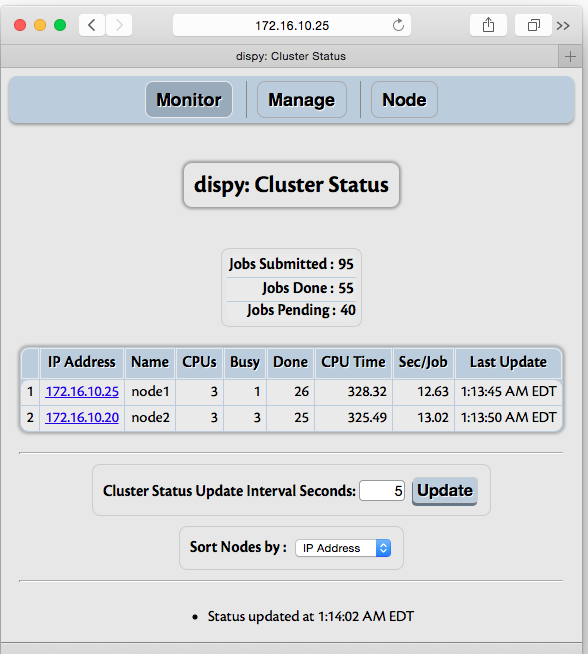

The information shows summary of jobs and nodes in cluster. Jobs summary shows total number of jobs submitted so far, done (finished or cancelled) and pending jobs. The nodes summary shows IP address, name (if available) of the node, number of CPUs used by dispy on that node, number of CPUs currently being used (shown as “Busy”), number of jobs done, total CPU time in seconds used by the jobs done on that node, number of seconds used per job and the latest time the node accepted a job for execution or finished executing job. The nodes are sorted by default on the IP address in descending order. The field to sort on can be changed; however, as other fields are not necessarily unique, sorting on other fields is inefficient, so if there are many nodes, especially with frequent updates, choose IP address as the field to sort. Sorting can be changed even after cluster is closed. ‘Show Job Arguments’ checkbox controls whether job arguments are shown in ‘Node’ page. If job are created with large data as arguments, it is recommended to disable this, as otherwise exchanging that data between scheduler and web browser can be quite inefficient.

## ***Node Information (Monitor / Manage Jobs)***

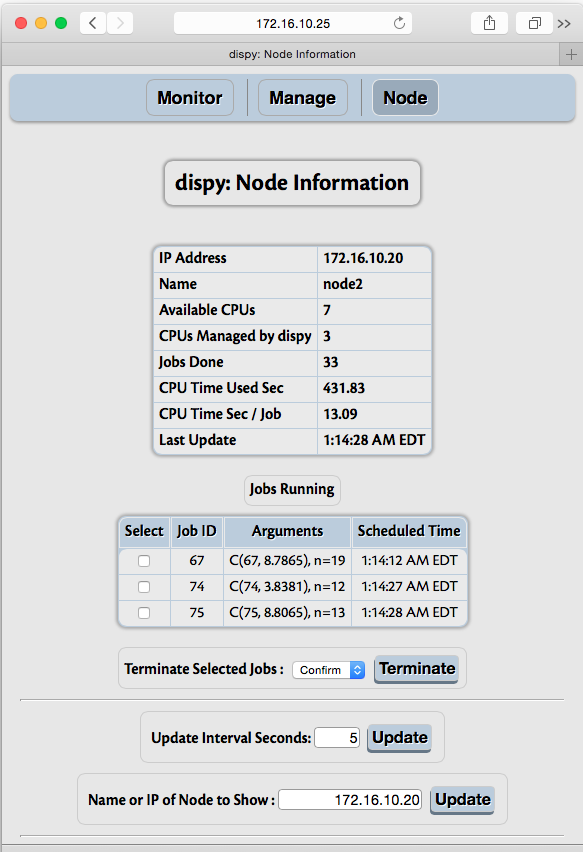

The summary of node includes number of CPUs available on the node, CPUs allocated for dispy (which may be less than available CPUs if –cpus argument was used to start dispynode (Server)), number of jobs done by the node, CPU time used and the last time it accepted a job or finished a job.

If the node is currently executing a job, they are shown with the ID for each job (job.id, associated by user after the job is submitted), arguments to job and the time job was scheduled. The ID and arguments to jobs are converted to strings by HTTP server before sending to the client. If any of these are instances of user provided classes, it may be useful to provide __str__ method, as done in the example above. Otherwise, Python’s default __str__ method may show it as simply an instance of a class, which may not be very useful.

“Data Sent” and “Data Received” rows show amount of data sent to / received from node. This information may be useful to understand application or network performance. Each time a job or file is sent, the size of (serialized) data is counted as data sent and each time a job reply or file is received, the size of (serialized) data is counted as data received. Note that overheads of protocol are not counted in these fields.

## ***Manage Cluster (Nodes)***

Additional nodes can be dynamically added to the cluster with Manage feature. The nodes can specified with host name or IP address, or alternately, with wildcards, as per nodes parameter of JobCluster. If name or IP address is used with JobCluster, desired CPUs can also be given. If wildcard is used for IP address or SharedJobCluster is used, then CPUs is ignored. Additionally, if JobCluster is used, the CPUs of current nodes in the cluster can be updated dynamically. If the CPUs are decreased from currently busy CPUs number, no additional jobs are scheduled beyond given number, but currently running jobs are left running. If it is necessary to immediately reduce CPUs used, currently running jobs can be terminated after reducing the CPUs to use.

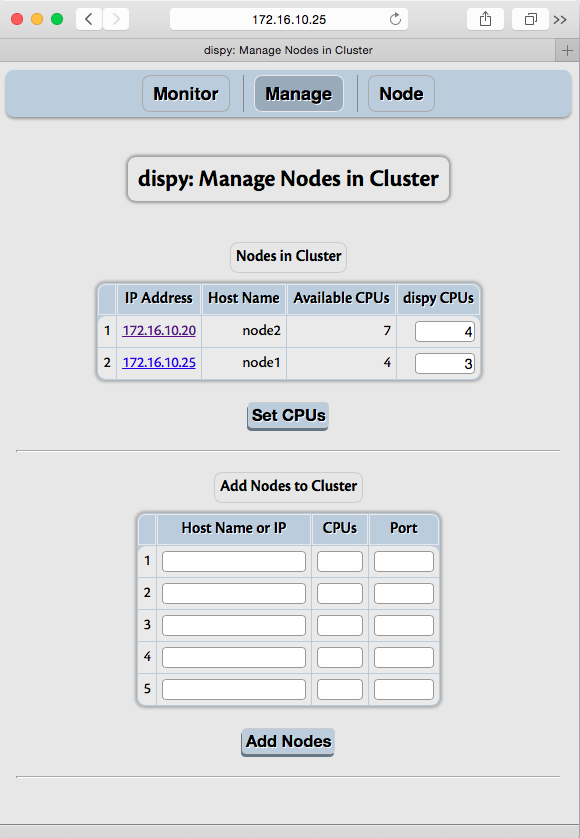

Monitor and Node sections have “Update Interval Seconds” input. Its initial value is the value of poll_sec parameter to HTTP Server. The client queries the server for updates at this interval. As mentioned above, depending on how frequently jobs are executed, this value may be increased or decreased. The updates can be disabled by giving the value 0 (or less than 0). The update can be forced any time (whether automatic updates are enabled or disabled) by clicking on the “Update” button.

# ***6. dispyadmin***

dispyadmin.py is a web server to control all or individual nodes (running dispynode (Server)) with a web browser. Although multiple admin servers can be running, it is recommended that only one instance is used for controling the nodes. Only nodes started with admin_secret option and same secret used with dispyadmin can be controlled. Nodes that have different secret or nodes started without admin_secret option are shown but without details such as available memory, CPUs being used etc.

### ***6.1. Admin Cluster(s)***

The page shows cluster(s), as shown in example below:

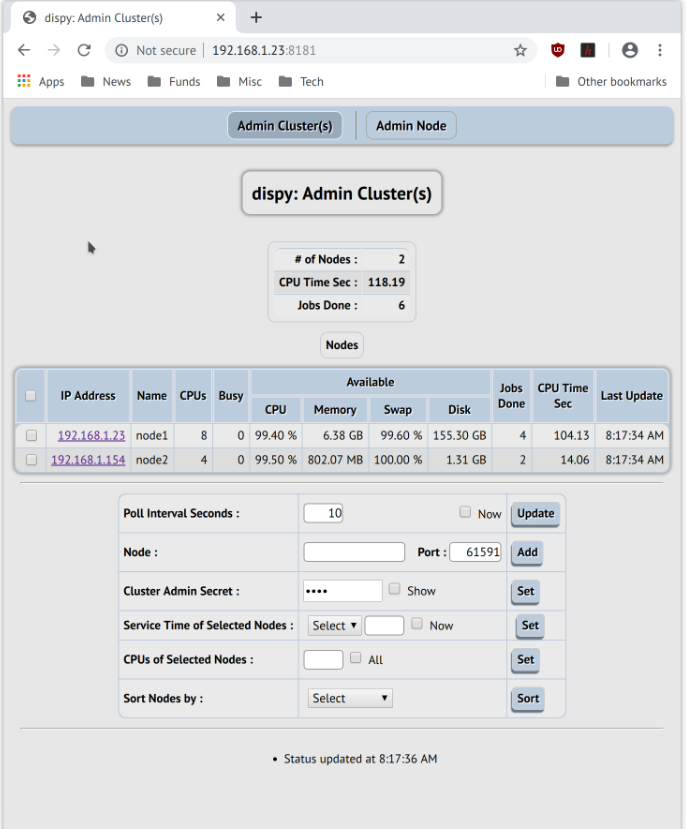

The table at the bottom of page has following controls:

Poll interval is number of seconds at which nodes are polled to get latest details as well as to update the cluster(s) on this page. If “Now” is selected, the interval is not updated, but nodes are polled right away.

If a node has not been detected (e.g., UDP packets used to discover nodes are lost or node is in remote network etc.), the node’s host name or IP address can be input (along with port number if necessary) to add that node. Once the node is found at the given address, it will appear in the cluster(s) table above.

An admin secret can be set to get details of nodes as well as to control them. If different nodes use different secrets, then those secrets can be set one at a time. Each time a secret is set, it is used to match with nodes; setting a new admin secret (to match with other nodes) doesn’t affect nodes that already matched. “Show” can be selected to show the secret in clear text or not.

The nodes in the cluster table are by default shown in no particular order. This can be changed by selecting ordering based on IP address, last time node information has been updated from that node etc.

The 2 controls below apply to selected nodes. The nodes can be selected / deselected with checkbox against each node, or all nodes can be selected / deselected with the checkbox in the table header of nodes.

Service times when selected nodes are allowed to execute jobs can be controlled by selecting the control (start / stop / end), the time for that control and set as appropriate. The time must in “HH:MM” format in where “HH” is 24-hour format (in the range 0 to 23) and “MM” is minutes (in the range 0 to 59). Alternately, “Now” can be selected in which case current time at the nodes is chosen. The times must be in increasing order from “Start” to “End”. If “Start” is set, dispynode starts accepting jobs from that time (jobs are not accepted before that time). If “Stop” is set, no new jobs are accepted from that time, but any executing jobs are allowed to execute. If “End” is set, any executing jobs are terminated and no new jobs are executed. The next day node will again accept jobs at the “Start” time (if set).

CPUs used by selected nodes can be set by specifying number (integer) of CPUs. If the number is positive, that many CPUs are used by dispy and if the number is negative, that many CPUs are not used by dispy (e.g., if a node has 8 processors and the input number is -2, then dispy will use 6 CPUs). If CPUs are reduced, currently executing jobs are not killed, but no new jobs are accepted until CPUs used are as set. “All” checkbox can be set to use all available processors on each selected node.

## **6.2. Admin Node**

At the top menu, “Admin Node” can be selected to show details about selected node.

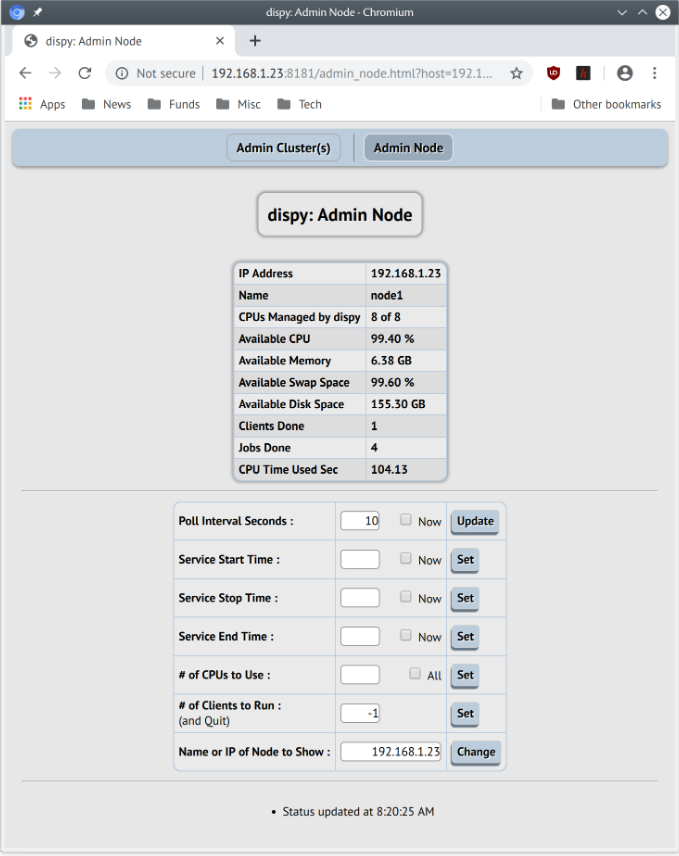

Most of the information and controls are same as shown in Admin Cluster(s) page. In addition to these, this page shows / controls number of clients serviced. To control the number of clients to run, set the number to positive number to run that many clients, 0 to accept no additional clients and to -1 to run forever. Once the node finishes selected number of clients, dispynode program terminates, so the node can’t be controlled until dispynode is manually restarted.

# ***Excercise***

1. dispy can be used as a command line tool (for simple cases, scheduling cron jobs); in this case the computations should only be programs and dependencies should only be files.:

2. A simple client program that distributes a program (say, ‘/path/to/program’), executes them with a sequence of numbers as arguments is:

3. Create a program. A canonical cluster that distributes computation ‘compute’ (Python function) to nodes (running dispynode (server) on a local network), schedules jobs with the cluster, gets jobs’ results and prints them is.

4. write a program distributes computation to be executed with instances of a class